Taken from Pytorch documentation. Created by Jeremy Howard

## MNIST data setup

In [1]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot
import numpy as np
import torch
import math

In [2]:
## Define Path for Data
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

## Create directory if not there
PATH.mkdir(parents=True, exist_ok=True)

## Download data
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
        
## Load Data
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


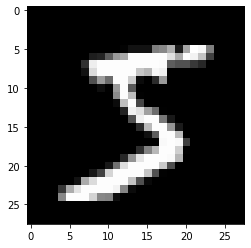

In [3]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
## Convert in torch.tensor

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## NN from scratch

In [5]:
## Initializing weight (1/sqrt(N))
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
## Define loss function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

## Define Model
def model(xb):
    return log_softmax(xb @ weights + bias)

In [40]:
## Forward Pass
bs = 64  # batch size
xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([3659.4778, 2359.3237, 3104.4150, 3798.2612, 2273.9587, 2999.9839,
        3039.2837, 2906.3892, 3538.7532, 2874.3267], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [90]:
## Negative Log-Likelihood function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

## Checking loss at random
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(-3625.6821, grad_fn=<NegBackward>)


In [9]:
## Defining accuracy of the model
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0469)


In [10]:
## Training a model
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1): ## Iterating through 50,000 images of batch 64
        #         set_trace()
        start_i = i * bs 
        end_i = start_i + bs
        xb = x_train[start_i:end_i] ## Getting x's
        yb = y_train[start_i:end_i] ## Getting y's
        pred = model(xb) ## Forward pass
        loss = loss_func(pred, yb) ## Compute loss

        loss.backward() ## Calculate gradient
        with torch.no_grad():
            weights -= weights.grad * lr ## weight updates
            bias -= bias.grad * lr ## bias updates
            weights.grad.zero_() ## making gradient zero
            bias.grad.zero_() ## making gradient zero

In [11]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0822, grad_fn=<NegBackward>) tensor(1.)


## Refactor using nn.Module

In [14]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [16]:
model = Mnist_Logistic()

In [17]:
print(loss_func(model(xb),yb))

tensor(-0.0868, grad_fn=<NegBackward>)


In [18]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_
    bias.grad.zero_

In [19]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p = p - p.grad * lr
                model.zero_grad()

fit()

In [20]:
print(loss_func(model(xb),yb))

tensor(-0.0868, grad_fn=<NegBackward>)


## Refactoring using nn.Linear

In [59]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)

    def forward(self, xb):
        return self.lin(xb)

In [60]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(-0.0160, grad_fn=<NegBackward>)


In [62]:
fit()

print(loss_func(model(xb), yb))

tensor(-0.0160, grad_fn=<NegBackward>)


## Refactor using Optim

In [36]:
from torch import optim

In [63]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=0.5)

In [64]:
model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(-0.0785, grad_fn=<NegBackward>)


In [66]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
fit()
print(loss_func(model(xb), yb))

tensor(-3578.5664, grad_fn=<NegBackward>)


## Refactor using Dataset

In [67]:
from torch.utils.data import TensorDataset

In [68]:
train_ds = TensorDataset(x_train, y_train)

In [69]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(-3578.5134, grad_fn=<NegBackward>)


## Refactor using DataLoader

In [70]:
from torch.utils.data import DataLoader

In [71]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [72]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(-3578.3691, grad_fn=<NegBackward>)


## Add validation

In [73]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [74]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(-1813.4518)
1 tensor(-3627.0759)


## Create Fit and get_data

In [77]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [78]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [79]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [81]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 -1817.403821875
1 -3634.697958203125


## Switch to CNN

In [84]:
import torch.nn.functional as F

In [85]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [87]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 nan
1 nan


## nn.Sequential

In [88]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [89]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 nan
1 nan


## Using your GPU

In [91]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [93]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [94]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [95]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 nan
1 nan
